In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns # Used for styling
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error

In [15]:
class PhysicsLayer(nn.Module):
    def __init__(self):
        super(PhysicsLayer, self).__init__()
        self.register_buffer('battery_capacity', torch.tensor(42.2))
        self.register_buffer('vehicle_mass', torch.tensor(1300.0))
        self.register_buffer('drag_coeff', torch.tensor(0.29))
        self.register_buffer('frontal_area', torch.tensor(2.38))
        self.register_buffer('air_density', torch.tensor(1.225))
        self.register_buffer('rolling_resistance', torch.tensor(0.01))
        self.register_buffer('gravity', torch.tensor(9.81))
        self.register_buffer('drivetrain_efficiency', torch.tensor(0.85))
        self.register_buffer('regen_efficiency', torch.tensor(0.7))
        self.register_buffer('aux_power', torch.tensor(1.5))
        self.register_buffer('temp_ref', torch.tensor(25.0))
        self.register_buffer('temp_coeff', torch.tensor(0.005))
        self.register_buffer('min_energy_per_km', torch.tensor(0.15))
        self.register_buffer('max_energy_per_km', torch.tensor(0.50))
    
    def calculate_driving_forces(self, velocity_kmh, acceleration_ms2, elevation_grade):
        velocity_ms = torch.clamp(velocity_kmh / 3.6, min=0.01)
        
        drag_force = 0.5 * self.air_density * self.drag_coeff * self.frontal_area * (velocity_ms ** 2)
        rolling_force = self.rolling_resistance * self.vehicle_mass * self.gravity
        grade_radians = torch.atan(torch.clamp(elevation_grade / 100.0, min=-0.3, max=0.3))
        gravity_force = self.vehicle_mass * self.gravity * torch.sin(grade_radians)
        accel_force = self.vehicle_mass * torch.clamp(acceleration_ms2, min=-5.0, max=5.0)
        
        return {
            'drag_force': drag_force,
            'rolling_force': rolling_force,
            'gravity_force': gravity_force,
            'accel_force': accel_force,
            'total_force': drag_force + rolling_force + gravity_force + accel_force,
            'velocity_ms': velocity_ms
        }
    
    def calculate_theoretical_power(self, velocity_kmh, acceleration_ms2, elevation_grade, ambient_temp):
        forces = self.calculate_driving_forces(velocity_kmh, acceleration_ms2, elevation_grade)
        wheel_power = forces['total_force'] * forces['velocity_ms'] / 1000.0

        temp_factor = 1.0 - self.temp_coeff * torch.abs(ambient_temp - self.temp_ref)
        adjusted_efficiency = self.drivetrain_efficiency * torch.clamp(temp_factor, min=0.7, max=1.0)

        motor_power = torch.where(
            wheel_power >= 0,
            wheel_power / adjusted_efficiency,
            wheel_power * self.regen_efficiency
        )
        total_power = motor_power + self.aux_power
        return torch.clamp(total_power, min=-50.0, max=100.0)
    
    def forward(self, predictions, inputs):
        velocity = torch.clamp(inputs[:, -1, 0], min=0.1)
        elevation = inputs[:, -1, 1]
        acceleration = inputs[:, -1, 4]
        ambient_temp = inputs[:, -1, 3]
        
        physics_power = self.calculate_theoretical_power(velocity, acceleration, elevation, ambient_temp)
        
        predicted_power = predictions['power'].squeeze()
        power_loss = F.huber_loss(predicted_power, physics_power, delta=5.0)
        
        soc_pred = predictions['soc'].squeeze()
        soc_bound_loss = torch.mean(
            F.relu(soc_pred - 1.0) + F.relu(-soc_pred)
        )
        
        power_magnitude_loss = torch.mean(F.relu(torch.abs(predicted_power) - 80.0))
        
        return {
            'power_physics': power_loss,
            'soc_constraint': soc_bound_loss,
            'power_magnitude': power_magnitude_loss,
            'total_physics': power_loss + 0.5 * soc_bound_loss + 0.1 * power_magnitude_loss
        }
    # More robust energy rate calculation
    def calculate_energy_consumption_rate(self, velocity_kmh, acceleration_ms2, elevation_grade, ambient_temp):
        power_kw = self.calculate_theoretical_power(velocity_kmh, acceleration_ms2, elevation_grade, ambient_temp)
        velocity_safe = torch.clamp(velocity_kmh, min=1.0, max=150.0)
        energy_rate = power_kw / velocity_safe
        return torch.clamp(energy_rate, 
                        min=self.min_energy_per_km, 
                        max=self.max_energy_per_km)

class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Linear(hidden_size, 1)
        
    def forward(self, lstm_output):
        weights = torch.softmax(self.attention(lstm_output), dim=1)
        attended_output = torch.sum(weights * lstm_output, dim=1)
        return attended_output

class EVRangePINN(nn.Module):
    def __init__(self, input_size=16, hidden_size=256, num_layers=3, dropout=0.3, physics_weight=0.5):
        super(EVRangePINN, self).__init__()
        self.physics_weight = physics_weight
        self.input_size = input_size
        
        self.input_projection = nn.Linear(input_size, hidden_size)
        
        self.lstm = nn.LSTM(
            hidden_size, hidden_size, num_layers, 
            dropout=dropout, batch_first=True, bidirectional=False
        )
        
        self.attention = AttentionLayer(hidden_size)
        
        self.physics_layer = PhysicsLayer()
        
        self.feature_extractor = nn.ModuleDict({
            'soc_features': nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.LayerNorm(hidden_size // 2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ),
            'power_features': nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.LayerNorm(hidden_size // 2),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
        })
        
        self.soc_predictor = nn.Sequential(
            nn.Linear(hidden_size // 2, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout // 2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
        self.power_predictor = nn.Sequential(
            nn.Linear(hidden_size // 2, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout // 2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
        self.range_estimator = nn.Sequential(
            nn.Linear(hidden_size + 2, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.ReLU()
        )
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.LSTM):
                for param in module.parameters():
                    if len(param.shape) >= 2:
                        nn.init.orthogonal_(param.data)
                    else:
                        nn.init.normal_(param.data)
    
    def calculate_range(self, soc_pred, power_pred, velocity):
        remaining_energy = soc_pred * self.physics_layer.battery_capacity
        
        power_consumption = torch.clamp(torch.abs(power_pred), min=1.0, max=80.0)
        velocity_safe = torch.clamp(velocity, min=1.0)
        
        energy_rate = torch.clamp(power_consumption / velocity_safe, min=0.10, max=0.60)
        range_pred = torch.clamp(remaining_energy / energy_rate, min=0.0, max=800.0)
        
        return range_pred
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        x = self.input_projection(x)
        
        lstm_out, (hidden, cell) = self.lstm(x)
        
        attended_features = self.attention(lstm_out)
        
        soc_features = self.feature_extractor['soc_features'](attended_features)
        power_features = self.feature_extractor['power_features'](attended_features)
        
        soc_pred = self.soc_predictor(soc_features)
        power_raw = self.power_predictor(power_features)
        power_pred = torch.tanh(power_raw) * 50.0
        
        velocity = x[:, -1, 0]
        range_pred = self.calculate_range(soc_pred.squeeze(), power_pred.squeeze(), velocity)
        
        range_features = torch.cat([attended_features, soc_pred, power_pred], dim=1)
        range_nn = self.range_estimator(range_features)
        
        final_range = 0.7 * range_pred.unsqueeze(1) + 0.3 * range_nn
        
        physics_losses = self.physics_layer(
            {'soc': soc_pred, 'power': power_pred}, x
        )
        
        return {
            'soc': soc_pred,
            'power': power_pred,
            'range': final_range,
            'physics_losses': physics_losses
        }

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, pred, target):
        mse = F.mse_loss(pred, target, reduction='none')
        pt = torch.exp(-mse)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * mse
        return focal_loss.mean()

class EVPINNTrainer:
    def __init__(self, model, device='cuda', physics_weight=0.3, data_weight=1.0):
        self.model = model.to(device)
        self.device = device
        self.physics_weight = physics_weight
        self.data_weight = data_weight
        
        self.optimizer = torch.optim.AdamW([
            {'params': [p for n, p in model.named_parameters() if 'physics' not in n], 'lr': 0.0005, 'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters() if 'physics' in n], 'lr': 0.0001, 'weight_decay': 0.005},
        ])
        
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=20, T_mult=2, eta_min=1e-6
        )
        
        self.focal_loss = FocalLoss(alpha=0.5, gamma=1.5)
        
    def train_step(self, batch_x, batch_y):
        self.model.train()
        self.optimizer.zero_grad()
        
        predictions = self.model(batch_x)
        physics_losses = predictions['physics_losses']
        
        soc_loss = self.focal_loss(predictions['soc'], batch_y[:, 0:1])
        power_loss = F.huber_loss(predictions['power'], batch_y[:, 1:2], delta=5.0)
        
        range_consistency_loss = F.mse_loss(
            predictions['range'], torch.clamp(predictions['range'], min=0.0, max=500.0)
        ) * 0.1
        
        data_loss = self.data_weight * (2.0 * soc_loss + power_loss + range_consistency_loss)
        physics_loss = self.physics_weight * physics_losses['total_physics']
        
        total_loss = data_loss + physics_loss
        
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        return {
            'total_loss': total_loss.item(),
            'data_loss': data_loss.item(),
            'soc_loss': soc_loss.item(),
            'power_loss': power_loss.item(),
            'physics_loss': physics_loss.item()
        }
    
    def validate(self, val_loader):
        self.model.eval()
        all_soc_true, all_soc_pred = [], []
        all_power_true, all_power_pred = [], []
        total_loss = 0.0
        num_batches = 0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                
                predictions = self.model(batch_x)
                
                all_soc_true.extend(batch_y[:, 0].cpu().numpy())
                all_soc_pred.extend(predictions['soc'].squeeze().cpu().numpy())
                all_power_true.extend(batch_y[:, 1].cpu().numpy())
                all_power_pred.extend(predictions['power'].squeeze().cpu().numpy())
                
                loss = F.mse_loss(predictions['soc'], batch_y[:, 0:1]) + \
                       F.mse_loss(predictions['power'], batch_y[:, 1:2])
                total_loss += loss.item()
                num_batches += 1
        
        soc_true = np.array(all_soc_true)
        soc_pred = np.array(all_soc_pred)
        power_true = np.array(all_power_true)
        power_pred = np.array(all_power_pred)
        
        soc_mae = mean_absolute_error(soc_true, soc_pred)
        power_mae = mean_absolute_error(power_true, power_pred)
        
        soc_var = np.var(soc_true)
        power_var = np.var(power_true)
        
        if soc_var > 1e-8:
            soc_r2 = max(r2_score(soc_true, soc_pred), -1.0)
        else:
            soc_r2 = 0.0
            
        if power_var > 1e-8:
            power_r2 = max(r2_score(power_true, power_pred), -1.0)
        else:
            power_r2 = 0.0
        
        return {
            'val_loss': total_loss / num_batches,
            'soc_mae': soc_mae,
            'power_mae': power_mae,
            'soc_r2': soc_r2,
            'power_r2': power_r2
        }

def create_data_loaders(processed_data_path, batch_size=64):
    with open(processed_data_path, 'rb') as f:
        data = pickle.load(f)
    
    X_train = torch.FloatTensor(data['X_train'])
    y_train = torch.FloatTensor(data['y_train'])
    X_test = torch.FloatTensor(data['X_test'])
    y_test = torch.FloatTensor(data['y_test'])
    
    # Enhanced SOC scaling with epsilon for numerical stability
    soc_min = y_train[:,0].min()
    soc_max = y_train[:,0].max()
    if (soc_min < 0 or soc_max > 1):
        print(f"Auto-rescaling SOC from [{soc_min:.2f},{soc_max:.2f}] to [0,1] range")
        range_eps = 1e-8  # Prevents division by zero
        y_train[:,0] = (y_train[:,0] - soc_min) / (soc_max - soc_min + range_eps)
        y_test[:,0] = (y_test[:,0] - soc_min) / (soc_max - soc_min + range_eps)
        # Verify scaling
        print(f"Verification - Train SOC: {y_train[:,0].min():.2f}-{y_train[:,0].max():.2f}")
    
    print(f"\nFinal Data Statistics:")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Power range: {y_train[:,1].min():.2f} to {y_train[:,1].max():.2f} kW")
    print(f"SOC range: {y_train[:,0].min():.2f} to {y_train[:,0].max():.2f}")
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, 
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=True,
                            num_workers=4,
                            pin_memory=True,
                            persistent_workers=True)  # Added for efficiency
    
    test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=False,
                           drop_last=False,
                           num_workers=4,
                           pin_memory=True)
    
    return train_loader, test_loader

def train_ev_pinn(processed_data_path, epochs=150, batch_size=64):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create data loaders here
    train_loader, test_loader = create_data_loaders(processed_data_path, batch_size)

    model = EVRangePINN(
        input_size=16,
        hidden_size=256,
        num_layers=3,
        dropout=0.3,
        physics_weight=0.3
    ).to(device)

    trainer = EVPINNTrainer(
        model, device,
        physics_weight=0.2,
        data_weight=1.0
    )

    history = {
        'train_loss': [],
        'val_loss': [],
        'soc_mae': [],
        'power_mae': [],
        'soc_r2': [],
        'power_r2': [],
        'physics_loss': []
    }

    best_val_loss = float('inf')
    early_stop_patience = 25
    patience_counter = 0

    print("Training starting...")

    for epoch in range(epochs):
        model.train()
        epoch_losses = []

        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            losses = trainer.train_step(batch_x, batch_y)
            epoch_losses.append(losses)

        avg_train_loss = np.mean([l['total_loss'] for l in epoch_losses])
        avg_physics_loss = np.mean([l['physics_loss'] for l in epoch_losses])

        val_metrics = trainer.validate(test_loader)

        history['train_loss'].append(avg_train_loss)
        history['physics_loss'].append(avg_physics_loss)
        history['val_loss'].append(val_metrics['val_loss'])
        history['soc_mae'].append(val_metrics['soc_mae'])
        history['power_mae'].append(val_metrics['power_mae'])
        history['soc_r2'].append(val_metrics['soc_r2'])
        history['power_r2'].append(val_metrics['power_r2'])

        trainer.scheduler.step()

        if val_metrics['val_loss'] < best_val_loss:
            best_val_loss = val_metrics['val_loss']
            torch.save(model.state_dict(), '15_07model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"\nEarly stopping at epoch {epoch}")
                break

        if epoch > 30 and epoch % 15 == 0:
            trainer.physics_weight = min(trainer.physics_weight * 1.05, 0.6)
            print(f"Increased physics weight to {trainer.physics_weight:.3f}")

        if epoch % 5 == 0 or epoch < 10:
            print(f"\nEpoch {epoch}/{epochs}")
            print(f"   Train Loss: {avg_train_loss:.4f} (Physics: {avg_physics_loss:.4f})")
            print(f"   Val Loss: {val_metrics['val_loss']:.4f}")
            print(f"   SOC Metrics: MAE={val_metrics['soc_mae']:.4f}, R²={val_metrics['soc_r2']:.3f}")
            print(f"   Power Metrics: MAE={val_metrics['power_mae']:.4f}, R²={val_metrics['power_r2']:.3f}")
            with torch.no_grad():
                sample_x, sample_y = next(iter(test_loader))
                sample_x = sample_x[:1].to(device)
                sample_y = sample_y[:1].to(device)
                pred = model(sample_x)
                print(f"\nSample Prediction:")
                print(f"   SOC: {pred['soc'].item():.3f} (True: {sample_y[0,0].item():.3f})")
                print(f"   Power: {pred['power'].item():.2f} kW (True: {sample_y[0,1].item():.2f})")

    with open('training_history.pkl', 'wb') as f:
        pickle.dump(history, f)
    model.load_state_dict(torch.load('15_07model.pth')) # Load the best model

    print("\nTraining completed")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Final SOC R²: {history['soc_r2'][-1]:.3f}")
    print(f"Final Power R²: {history['power_r2'][-1]:.3f}")

    # Return all necessary objects
    return model, trainer, history, train_loader, test_loader, device



In [3]:
if __name__ == "__main__":
    processed_data_path = r"C:\Users\DELL\ev range prediction project agni\new data\measurable data\cleaned_data\cleaned final data\sumo\sumo_integration\preprocess_cleaned\Trip B\processed_ev_data2.pkl"
    model, trainer, history, train_loader, test_loader, device = train_ev_pinn(processed_data_path, epochs=150, batch_size=64)

Using device: cuda

Final Data Statistics:
X_train shape: torch.Size([296553, 15, 16]), y_train shape: torch.Size([296553, 2])
Power range: 0.00 to 1.00 kW
SOC range: 0.00 to 1.00
Training starting...

Epoch 0/150
   Train Loss: 0.3586 (Physics: 0.0818)
   Val Loss: 0.0045
   SOC Metrics: MAE=0.0465, R²=0.933
   Power Metrics: MAE=0.0157, R²=0.958

Sample Prediction:
   SOC: 0.194 (True: 0.252)
   Power: 0.54 kW (True: 0.53)

Epoch 1/150
   Train Loss: 0.0016 (Physics: 0.0009)
   Val Loss: 0.0027
   SOC Metrics: MAE=0.0323, R²=0.963
   Power Metrics: MAE=0.0120, R²=0.967

Sample Prediction:
   SOC: 0.255 (True: 0.252)
   Power: 0.53 kW (True: 0.53)

Epoch 2/150
   Train Loss: 0.0011 (Physics: 0.0008)
   Val Loss: 0.0035
   SOC Metrics: MAE=0.0391, R²=0.948
   Power Metrics: MAE=0.0147, R²=0.970

Sample Prediction:
   SOC: 0.186 (True: 0.252)
   Power: 0.52 kW (True: 0.53)

Epoch 3/150
   Train Loss: 0.0010 (Physics: 0.0007)
   Val Loss: 0.0035
   SOC Metrics: MAE=0.0397, R²=0.946
   Po

In [16]:
# Set global font settings for consistency
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 22,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'figure.titlesize': 24 # For suptitle in comprehensive plots
})
# Set Seaborn style for better aesthetics
sns.set_theme(style="whitegrid", palette="deep")


def plot_training_history(history, save_dir='plots'):
    """
    Plot training metrics: Training Loss, Validation Loss, and Physics Loss over epochs.
    """
    os.makedirs(save_dir, exist_ok=True)
    epochs = np.arange(len(history['train_loss']))

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history['train_loss'], label='Training Loss', color='blue', linewidth=2.5)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='red', linewidth=2.5)
    plt.plot(epochs, history['physics_loss'], label='Physics Loss', color='green', linestyle=':', linewidth=2.5, alpha=0.7)

    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_validation_physics_loss.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Example usage (assuming 'history' dictionary is available from training)
# plot_training_history(history)

In [17]:


def plot_prediction_accuracy(model, test_loader, device, save_dir='plots'):
    """
    Plot scatter plots comparing predicted vs true SOC and Power values,
    and histograms of their prediction errors.
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    all_soc_true, all_soc_pred = [], []
    all_power_true, all_power_pred = [], []
    all_range_pred = [] # Collect range for later use if needed

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            predictions = model(batch_x)

            all_soc_true.extend(batch_y[:, 0].cpu().numpy())
            all_soc_pred.extend(predictions['soc'].squeeze().cpu().numpy())
            all_power_true.extend(batch_y[:, 1].cpu().numpy())
            all_power_pred.extend(predictions['power'].squeeze().cpu().numpy())
            all_range_pred.extend(predictions['range'].squeeze().cpu().numpy())

    soc_true = np.array(all_soc_true)
    soc_pred = np.array(all_soc_pred)
    power_true = np.array(all_power_true)
    power_pred = np.array(all_power_pred)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12)) # Adjusted figsize for more space
    fig.suptitle('Model Prediction Accuracy', fontsize=24, fontweight='bold')

    # SOC Predictions (True vs. Predicted)
    axes[0, 0].scatter(soc_true, soc_pred, alpha=0.6, s=20, color='teal')
    axes[0, 0].plot([0, 1], [0, 1], 'r--', linewidth=2.5, label='Perfect Prediction') # SOC is [0,1]
    soc_r2 = r2_score(soc_true, soc_pred)
    soc_mae = mean_absolute_error(soc_true, soc_pred)
    axes[0, 0].set_title(f'SOC Predictions (R² = {soc_r2:.3f}, MAE = {soc_mae:.4f})')
    axes[0, 0].set_xlabel('True SOC')
    axes[0, 0].set_ylabel('Predicted SOC')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_aspect('equal', adjustable='box') # Ensure square aspect ratio
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1)

    # Power Predictions (True vs. Predicted)
    axes[0, 1].scatter(power_true, power_pred, alpha=0.6, s=20, color='darkorange')
    power_min = min(power_true.min(), power_pred.min())
    power_max = max(power_true.max(), power_pred.max())
    axes[0, 1].plot([power_min, power_max], [power_min, power_max], 'r--', linewidth=2.5, label='Perfect Prediction')
    power_r2 = r2_score(power_true, power_pred)
    power_mae = mean_absolute_error(power_true, power_pred)
    axes[0, 1].set_title(f'Power Predictions (R² = {power_r2:.3f}, MAE = {power_mae:.2f} kW)')
    axes[0, 1].set_xlabel('True Power (kW)')
    axes[0, 1].set_ylabel('Predicted Power (kW)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_aspect('equal', adjustable='box') # Ensure square aspect ratio
    axes[0, 1].set_xlim(power_min, power_max)
    axes[0, 1].set_ylim(power_min, power_max)


    # SOC Error Distribution
    soc_errors = soc_pred - soc_true
    axes[1, 0].hist(soc_errors, bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
    axes[1, 0].axvline(x=0, color='navy', linestyle='--', linewidth=2)
    axes[1, 0].set_title(f'SOC Error Distribution')
    axes[1, 0].set_xlabel('SOC Prediction Error')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)

    # Power Error Distribution
    power_errors = power_pred - power_true
    axes[1, 1].hist(power_errors, bins=50, alpha=0.7, edgecolor='black', color='mediumpurple')
    axes[1, 1].axvline(x=0, color='navy', linestyle='--', linewidth=2)
    axes[1, 1].set_title(f'Power Error Distribution')
    axes[1, 1].set_xlabel('Power Prediction Error (kW)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
    plt.savefig(os.path.join(save_dir, 'prediction_accuracy_errors_combined.png'), dpi=300, bbox_inches='tight')
    plt.show()

    return {
        'soc_true': all_soc_true,
        'soc_pred': all_soc_pred,
        'power_true': all_power_true,
        'power_pred': all_power_pred,
        'range_pred': all_range_pred # Return this for further range plots
    }

# Example usage (assuming 'model', 'test_loader', 'device' are available)
# predictions_data = plot_prediction_accuracy(model, test_loader, device)

In [18]:
def plot_physics_analysis(model, test_loader, device, save_dir='plots'):
    """
    Analyze physics-informed predictions, comparing model power to physics power
    and showing relationships with key driving parameters.
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    physics_powers = []
    predicted_powers = []
    velocities = []
    elevations = []
    temperatures = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            predictions = model(batch_x)

            # Calculate physics-based power for comparison
            velocity = batch_x[:, -1, 0]
            elevation = batch_x[:, -1, 1]
            acceleration = batch_x[:, -1, 4] # Assuming acceleration is at index 4
            ambient_temp = batch_x[:, -1, 3] # Assuming ambient_temp is at index 3

            physics_power = model.physics_layer.calculate_theoretical_power(
                velocity, acceleration, elevation, ambient_temp
            )

            physics_powers.extend(physics_power.cpu().numpy())
            predicted_powers.extend(predictions['power'].squeeze().cpu().numpy())
            velocities.extend(velocity.cpu().numpy())
            elevations.extend(elevation.cpu().numpy())
            temperatures.extend(ambient_temp.cpu().numpy())

    fig, axes = plt.subplots(2, 2, figsize=(16, 12)) # Adjusted figsize
    fig.suptitle('Physics-Informed Analysis of Power Prediction', fontsize=24, fontweight='bold')

    # Physics vs Predicted Power
    ax = axes[0, 0]
    ax.scatter(physics_powers, predicted_powers, alpha=0.6, s=20, color='royalblue')
    min_p, max_p = min(min(physics_powers), min(predicted_powers)), max(max(physics_powers), max(predicted_powers))
    ax.plot([min_p, max_p], [min_p, max_p], 'r--', linewidth=2.5, label='Perfect Agreement')
    ax.set_xlabel('Physics-Based Power (kW)')
    ax.set_ylabel('Model Predicted Power (kW)')
    ax.set_title('Model Power vs. Physics Power')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Predicted Power vs Velocity
    ax = axes[0, 1]
    ax.scatter(velocities, predicted_powers, alpha=0.6, s=20, label='Model Predicted', color='limegreen')
    # Optional: Plot physics power vs velocity
    ax.scatter(velocities, physics_powers, alpha=0.3, s=15, label='Physics-Based', color='gray')
    ax.set_xlabel('Velocity (km/h)')
    ax.set_ylabel('Power (kW)')
    ax.set_title('Power vs. Velocity Relationship')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Predicted Power vs Elevation
    ax = axes[1, 0]
    ax.scatter(elevations, predicted_powers, alpha=0.6, s=20, label='Model Predicted', color='purple')
    # Optional: Plot physics power vs elevation
    ax.scatter(elevations, physics_powers, alpha=0.3, s=15, label='Physics-Based', color='gray')
    ax.set_xlabel('Elevation Grade (%)')
    ax.set_ylabel('Power (kW)')
    ax.set_title('Power vs. Elevation Grade Relationship')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Predicted Power vs Temperature
    ax = axes[1, 1]
    ax.scatter(temperatures, predicted_powers, alpha=0.6, s=20, label='Model Predicted', color='brown')
    # Optional: Plot physics power vs temperature
    ax.scatter(temperatures, physics_powers, alpha=0.3, s=15, label='Physics-Based', color='gray')
    ax.set_xlabel('Ambient Temperature (°C)')
    ax.set_ylabel('Power (kW)')
    ax.set_title('Power vs. Ambient Temperature Relationship')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(os.path.join(save_dir, 'physics_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Example usage (assuming 'model', 'test_loader', 'device' are available)
# plot_physics_analysis(model, test_loader, device)

In [19]:
def create_energy_heatmap(model, device, temp=25.0, grade=0.0, save_dir='plots'):
    """
    Create a heatmap of physics-based energy consumption (kWh/km)
    across velocity and acceleration ranges.
    """
    os.makedirs(save_dir, exist_ok=True)
    physics_layer = model.physics_layer # Access the physics layer from the model
    velocities = np.linspace(5, 120, 50)  # km/h
    accelerations = np.linspace(-3, 3, 50)  # m/s²
    energy_grid = np.zeros((len(velocities), len(accelerations)))

    # Create fixed temperature and grade tensors
    temp_tensor = torch.full((1,), temp, device=device)
    grade_tensor = torch.full((1,), grade, device=device)

    with torch.no_grad():
        for i, v in enumerate(velocities):
            for j, a in enumerate(accelerations):
                v_tensor = torch.tensor([v], dtype=torch.float32, device=device)
                a_tensor = torch.tensor([a], dtype=torch.float32, device=device)

                energy_rate = physics_layer.calculate_energy_consumption_rate(
                    v_tensor, a_tensor, grade_tensor, temp_tensor
                )
                energy_grid[i, j] = energy_rate.item()

    plt.figure(figsize=(14, 10)) # Increased figsize for better readability
    ax = sns.heatmap(
        energy_grid.T, # Transpose to have acceleration on x-axis and velocity on y-axis
        cmap="viridis_r", # Reverse viridis to have higher consumption be darker
        xticklabels=np.round(accelerations[::5], 1), # Label every 5th tick
        yticklabels=np.round(velocities[::5], 0), # Label every 5th tick
        cbar_kws={'label': 'Energy Consumption (kWh/km)'},
        square=False # Do not force square cells
    )

    # Set labels and title with increased font size
    ax.set_xlabel('Acceleration (m/s²)', fontsize=20)
    ax.set_ylabel('Velocity (km/h)', fontsize=20)
    ax.set_title('Physics-Based Energy Consumption Heatmap\n'
                  f'(Temp: {temp}°C, Grade: {grade}%)', fontsize=22)

    # Set font sizes for ticks
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, rotation=45) # Keep x-axis labels horizontal
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18, rotation=0) # Keep y-axis labels horizontal
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label('Energy Consumption (kWh/km)', fontsize=20)

    # Add contour lines for specific energy consumption levels
    # Ensure levels cover the range of energy_grid
    contour = ax.contour(
        energy_grid.T, # Contour on transposed grid
        levels=[0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45], # Example levels, adjust as needed
        colors='white',
        linewidths=1.5
    )
    plt.clabel(contour, inline=True, fontsize=16, fmt='%1.2f')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'energy_consumption_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Example usage (assuming 'model' and 'device' are available)
# create_energy_heatmap(model, device, temp=25.0, grade=0.0)

In [20]:
def plot_range_predictions(predictions_dict, save_dir='plots'):
    """
    Plot range prediction analysis: distribution and relationships with SOC and Power.
    """
    os.makedirs(save_dir, exist_ok=True)
    soc_pred = np.array(predictions_dict['soc_pred'])
    power_pred = np.array(predictions_dict['power_pred'])
    range_pred = np.array(predictions_dict['range_pred'])

    fig, axes = plt.subplots(1, 3, figsize=(20, 7)) # Single row for compact view
    fig.suptitle('Predicted Range Analysis', fontsize=24, fontweight='bold')

    # Range Distribution
    ax = axes[0]
    ax.hist(range_pred, bins=50, alpha=0.8, edgecolor='black', color='dodgerblue')
    ax.set_xlabel('Predicted Range (km)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Predicted Range Distribution (Mean: {np.mean(range_pred):.1f} km)')
    ax.grid(True, alpha=0.3)

    # Range vs SOC
    ax = axes[1]
    ax.scatter(soc_pred, range_pred, alpha=0.6, s=20, color='forestgreen')
    ax.set_xlabel('Predicted SOC')
    ax.set_ylabel('Predicted Range (km)')
    ax.set_title('Predicted Range vs. Predicted SOC')
    ax.grid(True, alpha=0.3)

    # Range vs Power Consumption
    ax = axes[2]
    ax.scatter(power_pred, range_pred, alpha=0.6, s=20, color='sandybrown')
    ax.set_xlabel('Predicted Power (kW)')
    ax.set_ylabel('Predicted Range (km)')
    ax.set_title('Predicted Range vs. Predicted Power Consumption')
    ax.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.92]) # Adjust rect for suptitle
    plt.savefig(os.path.join(save_dir, 'range_prediction_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Example usage (assuming 'predictions_data' is available from plot_prediction_accuracy)
# plot_range_predictions(predictions_data)

In [21]:
class AttentionAnalyzer(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.model = original_model
        # Freeze all parameters
        for param in self.model.parameters():
            param.requires_grad_(False)
    
    def forward(self, x):
        # Run until the attention layer
        x = self.model.input_projection(x)
        lstm_out, _ = self.model.lstm(x)
        
        # Get attention weights (replicating your AttentionLayer logic)
        attention_scores = self.model.attention.attention(lstm_out)  # [batch, seq_len, 1]
        attention_weights = torch.softmax(attention_scores, dim=1)
        
        return attention_weights.squeeze(-1)  # [batch, seq_len]

def plot_attention_heatmap(model, test_loader, device, num_samples=5, save_dir='plots'):
    """
    Plots a heatmap of attention weights across timesteps for a few sample inputs.
    """
    os.makedirs(save_dir, exist_ok=True)
    attention_model = AttentionAnalyzer(model)
    
    # Get sample data
    sample_x, _ = next(iter(test_loader))
    sample_x = sample_x[:num_samples].to(device)

    # Extract attention weights
    with torch.no_grad():
        attn_weights = attention_model(sample_x).cpu().numpy()

    plt.figure(figsize=(14, 8)) # Adjusted figsize
    sns.heatmap(
        attn_weights,
        annot=True,
        fmt=".2f", # Format to 2 decimal places
        cmap="YlGnBu", # A more visually appealing colormap for weights
        xticklabels=[f"t-{i}" for i in range(attn_weights.shape[1] - 1, -1, -1)], # Reversing for t-0, t-1 etc.
        yticklabels=[f"Sample {i+1}" for i in range(num_samples)],
        linewidths=.5, # Add lines between cells
        linecolor='lightgray'
    )
    plt.title("Attention Weights Across Timesteps", fontsize=22)
    plt.xlabel("Lookback Timesteps (t-0 is current, t-1 is previous)", fontsize=20)
    plt.ylabel("Input Samples", fontsize=20)
    plt.xticks(fontsize=18, rotation=45) # Rotate x-labels for clarity
    plt.yticks(fontsize=18, rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'attention_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()

Generating plots...


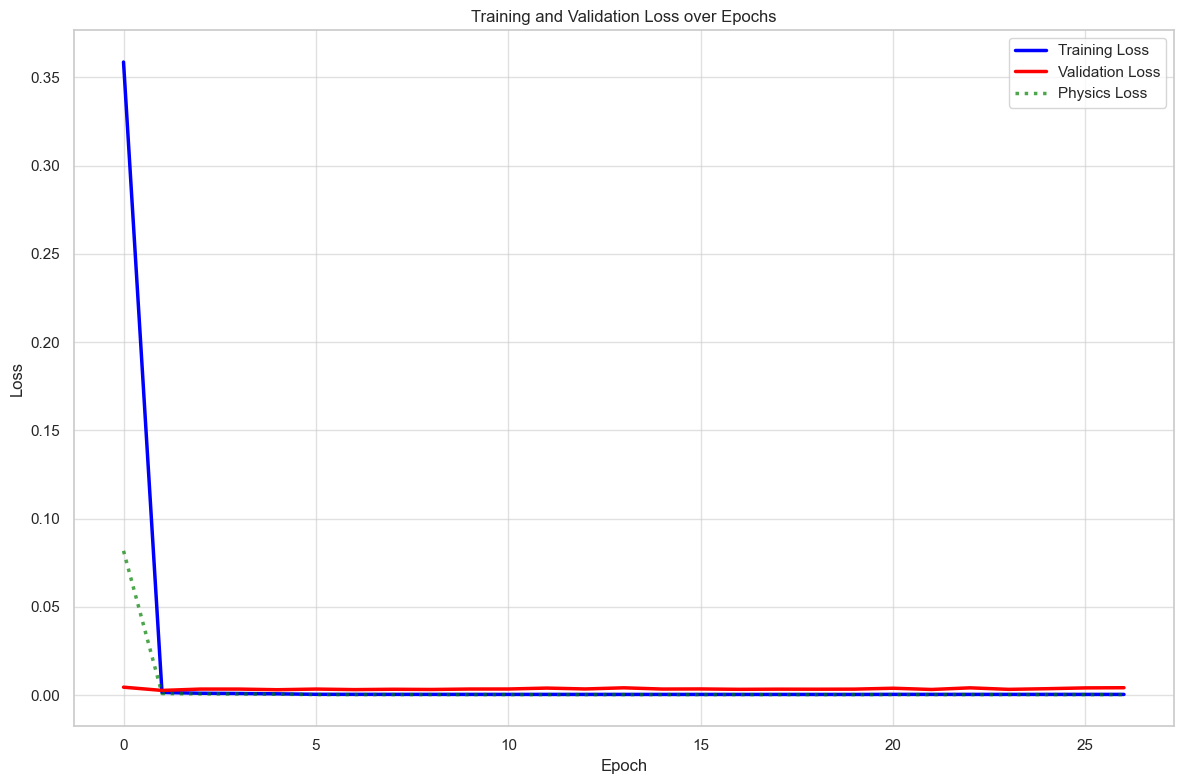

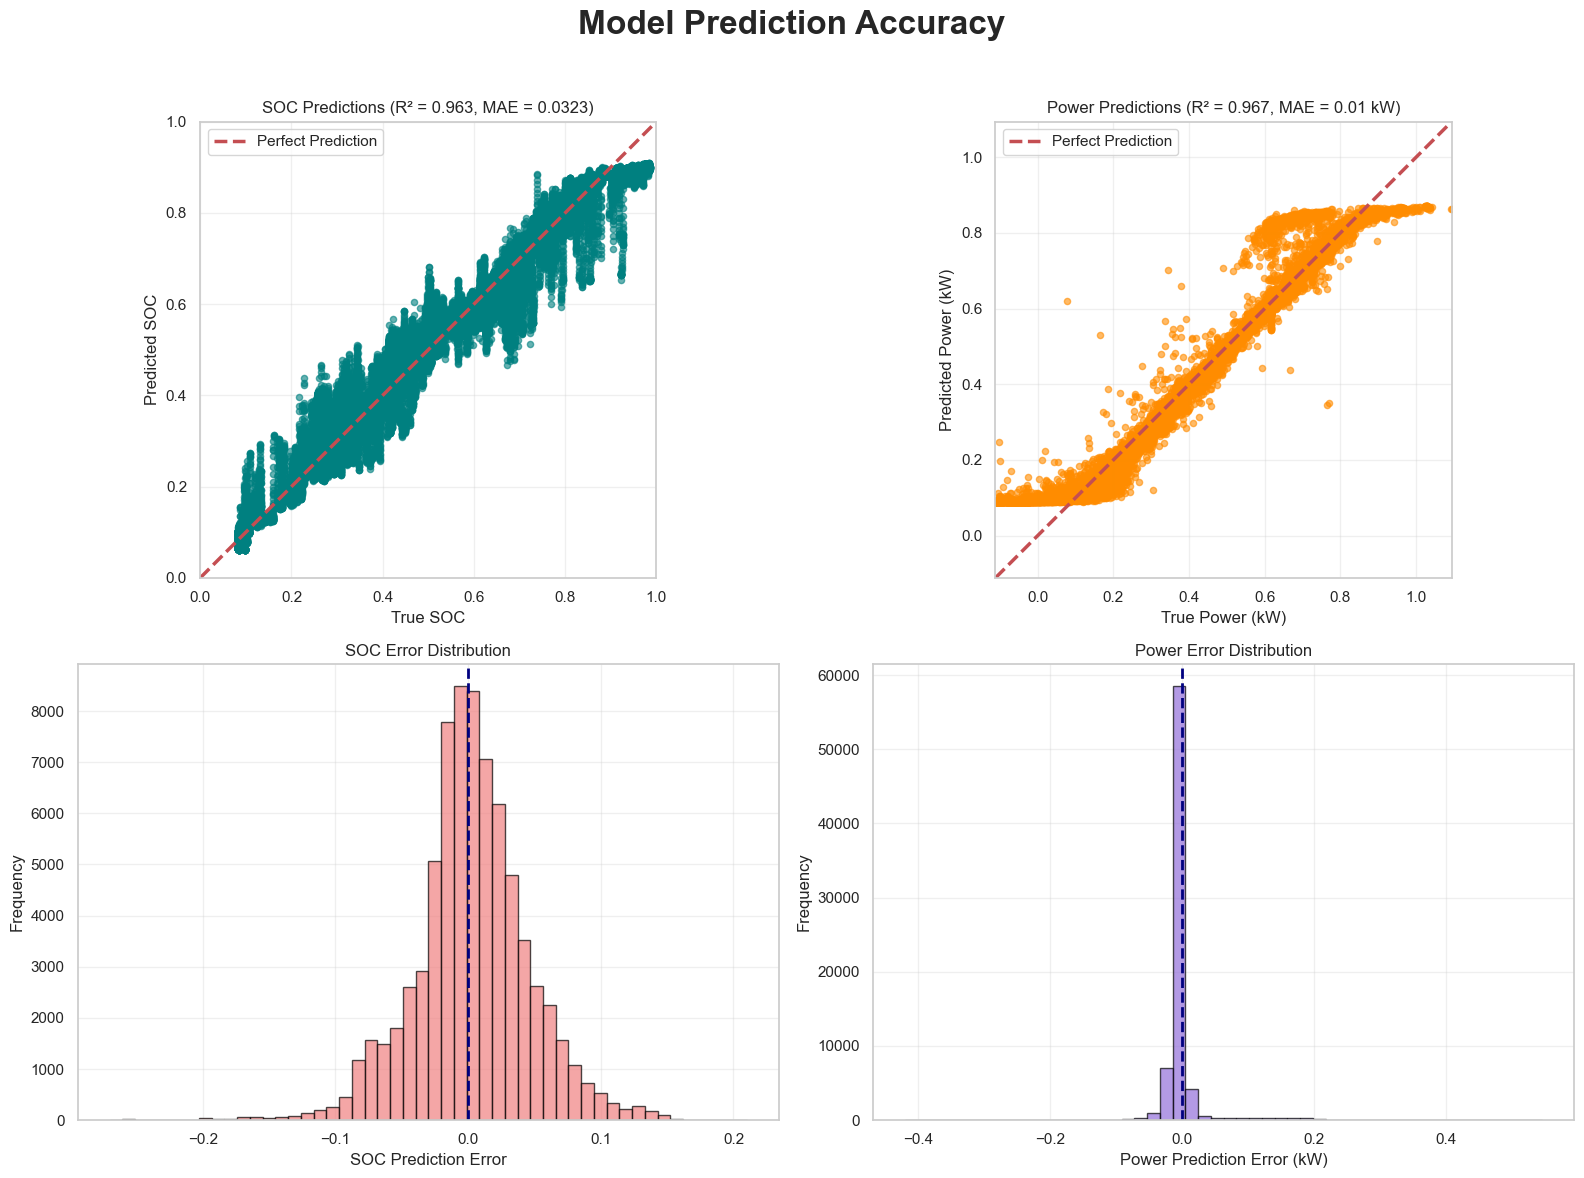

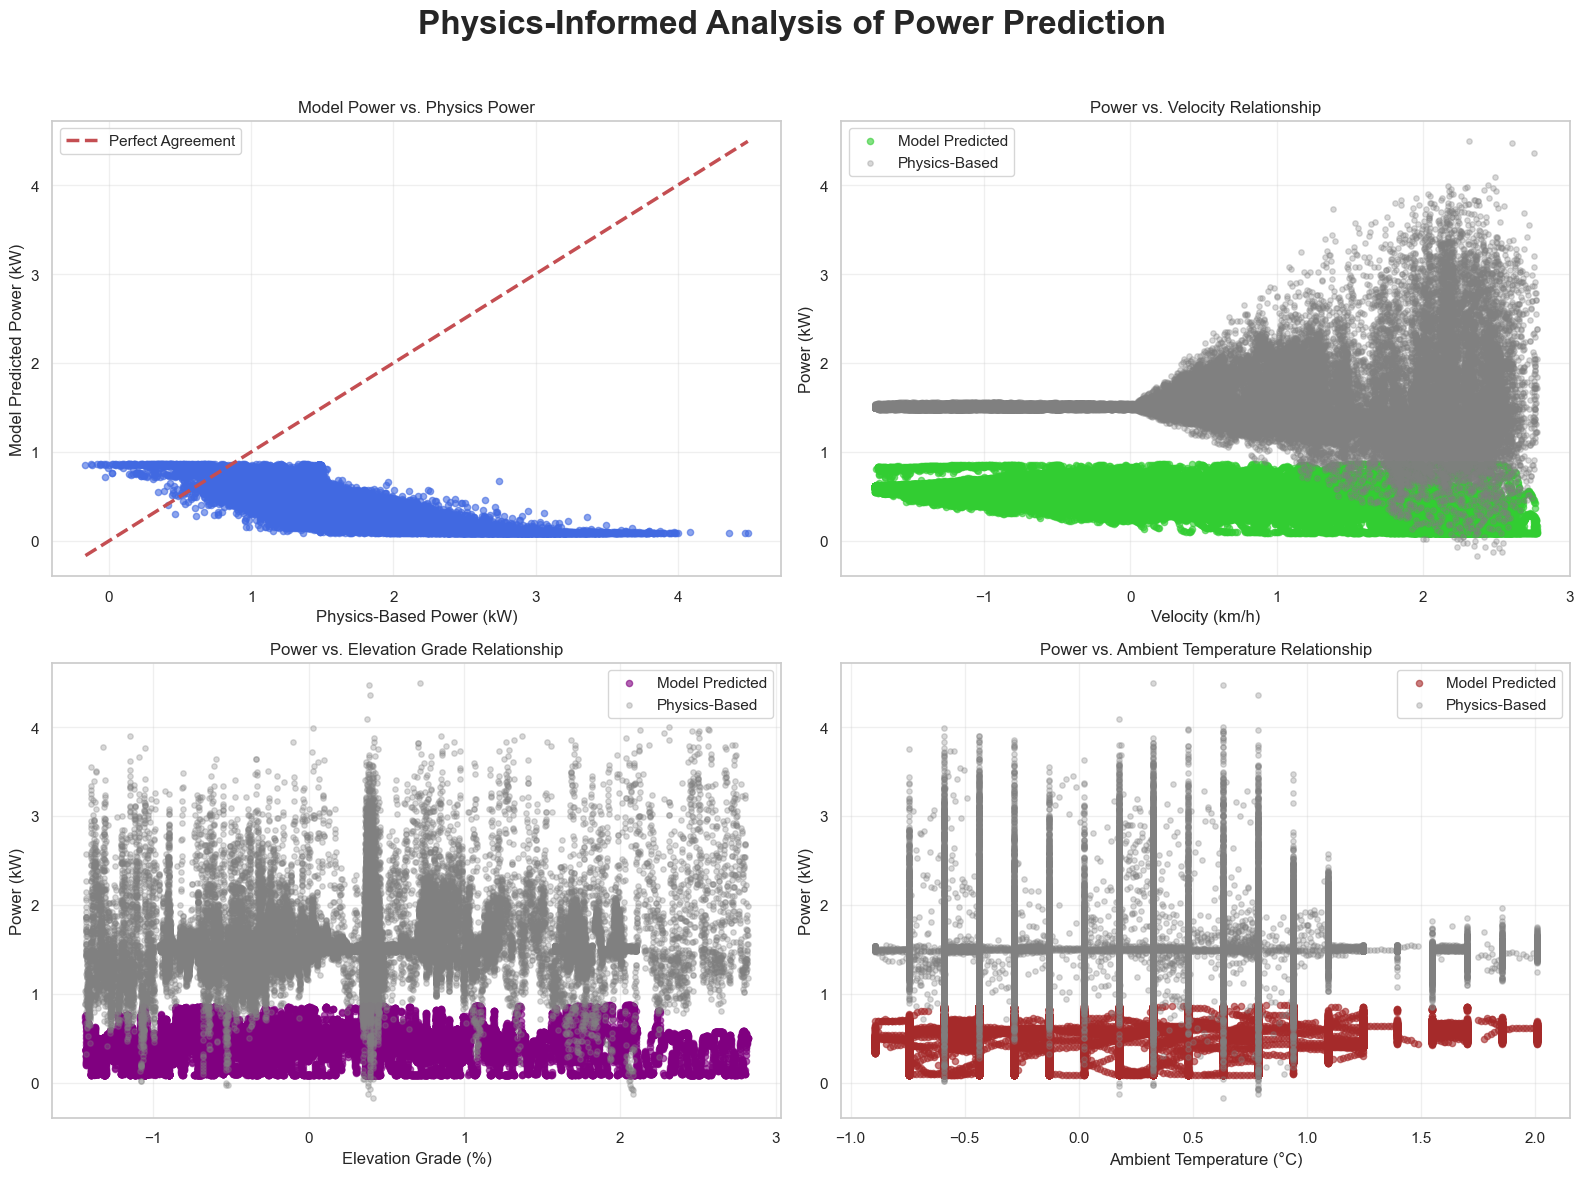

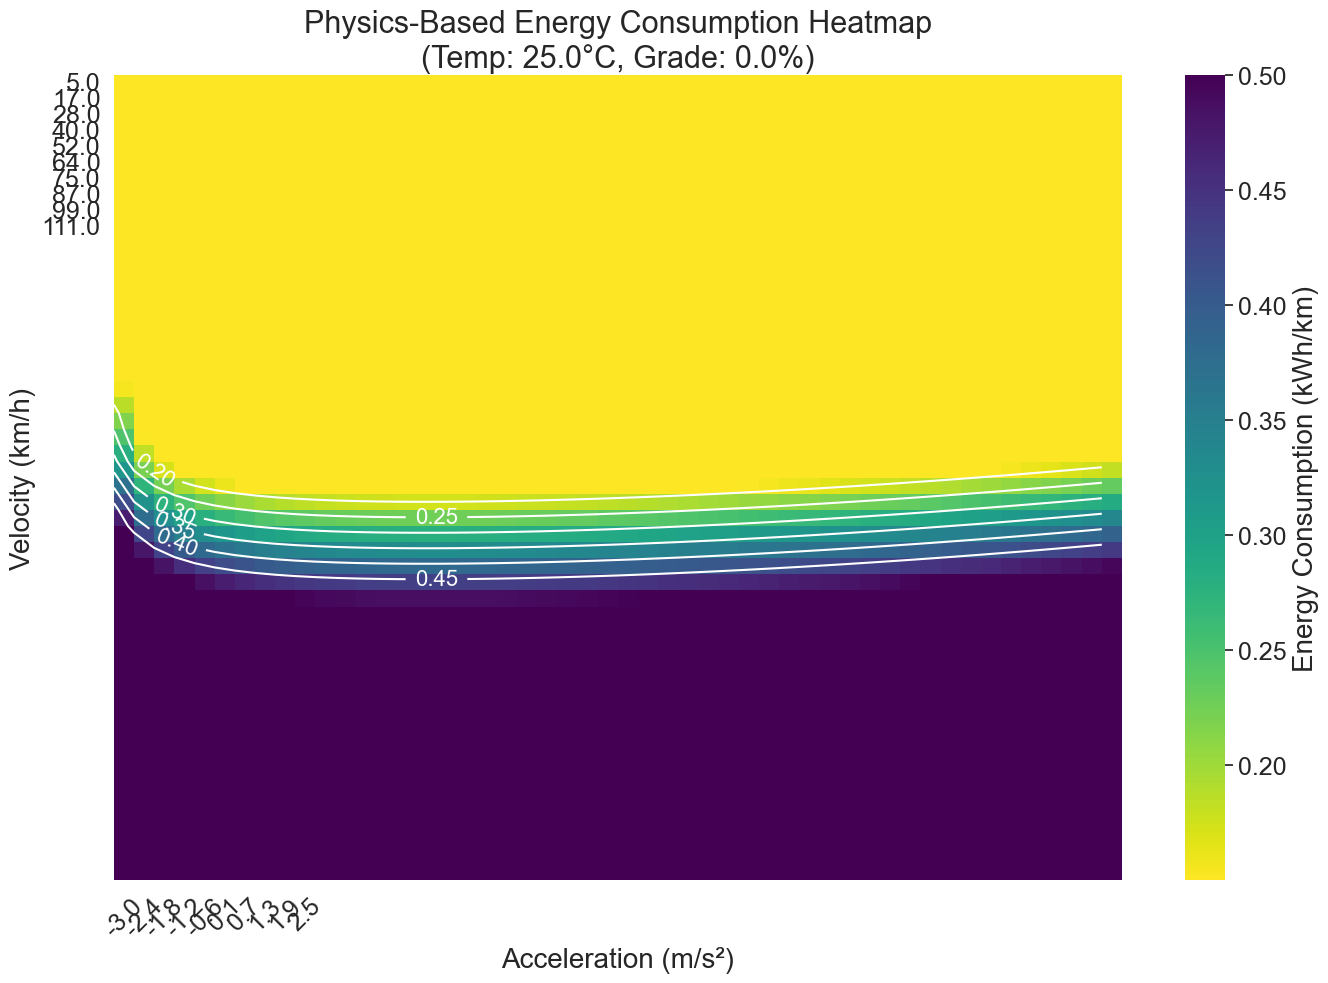

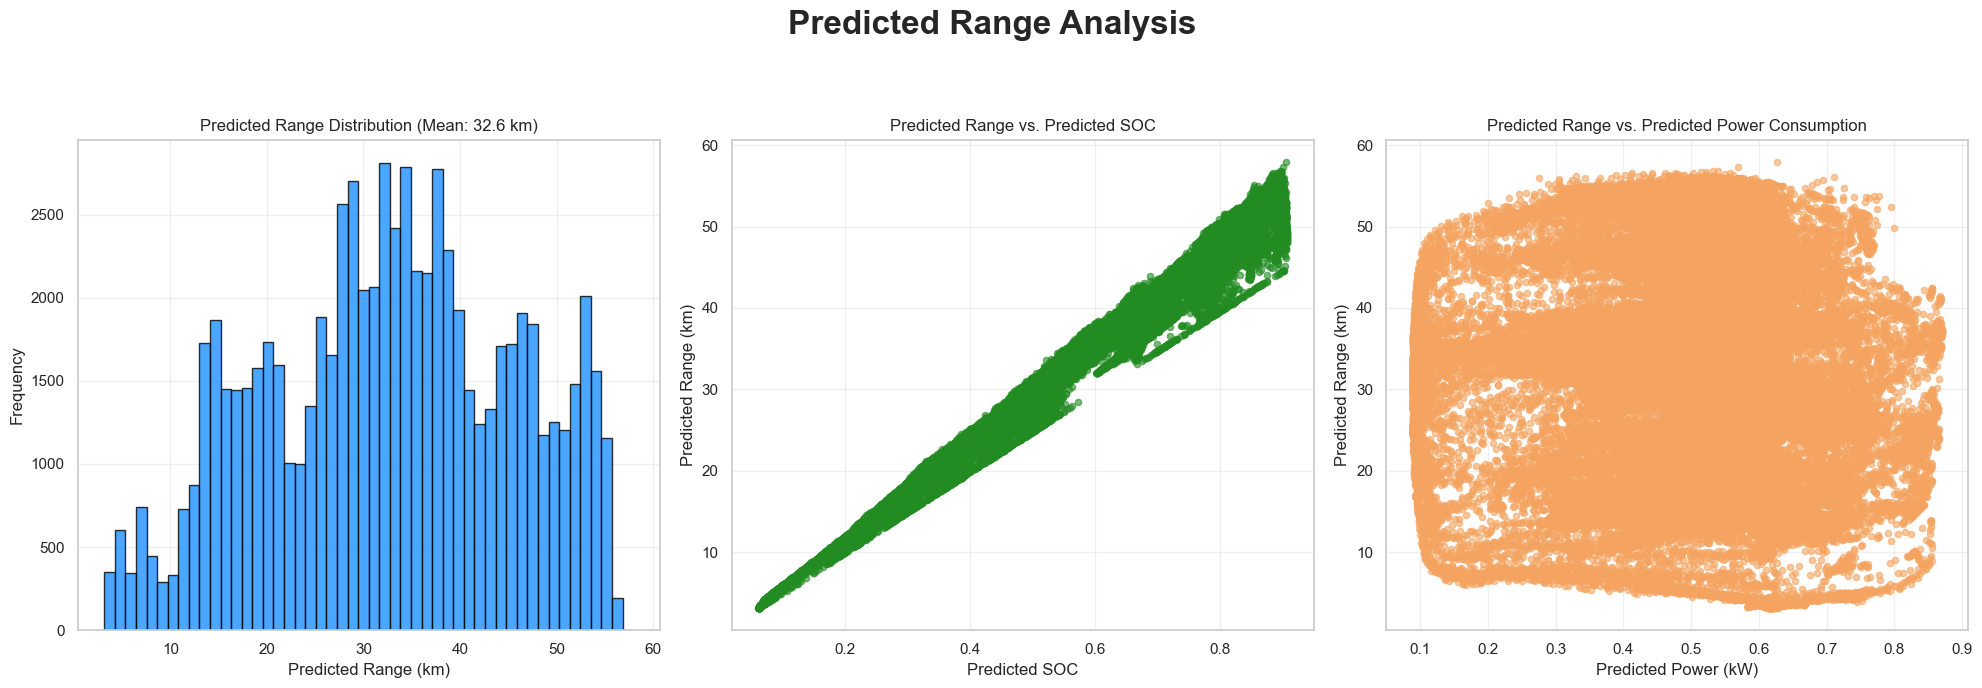

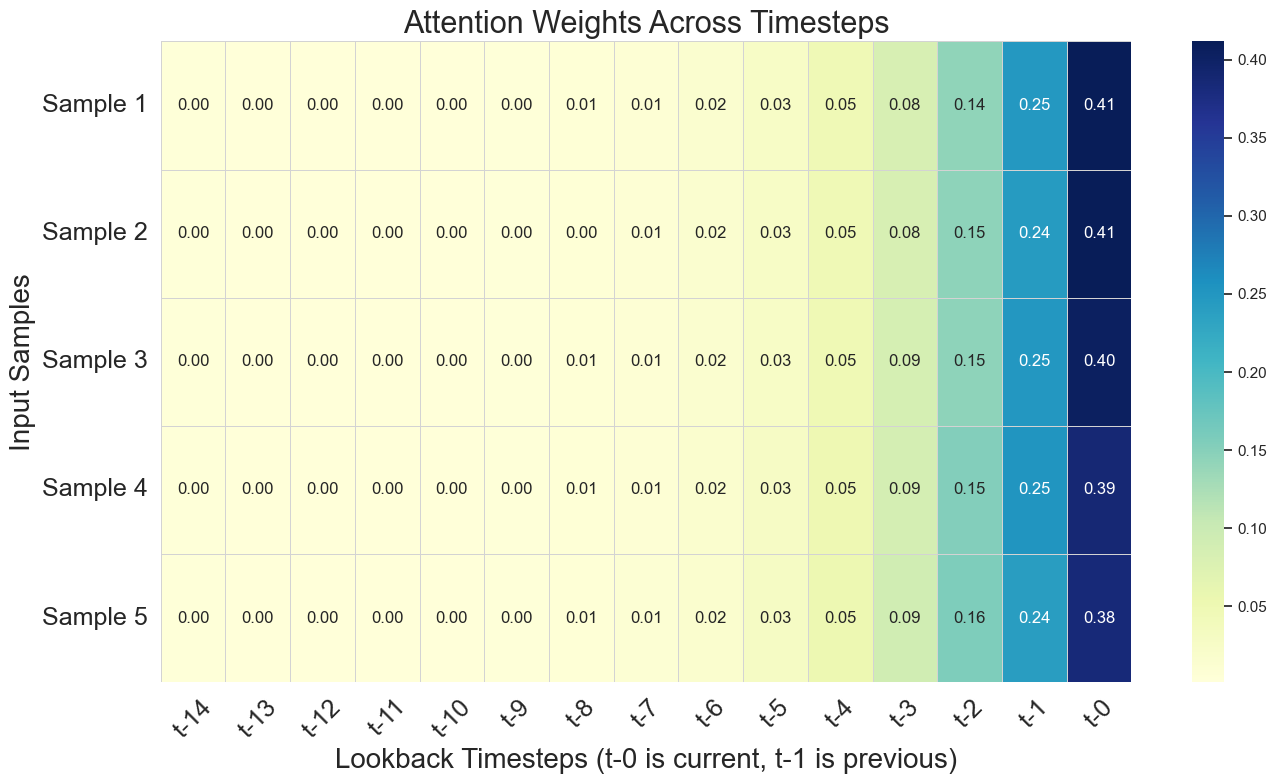


All required plots saved to 'ev_pinn_plots' directory.


In [10]:
# Set the directory for saving plots
plots_save_directory = 'ev_pinn_plots'
os.makedirs(plots_save_directory, exist_ok=True) # Ensure the directory exists

print("Generating plots...")

# 1. Plot Training History
plot_training_history(history, save_dir=plots_save_directory)

# 2. Plot Prediction Accuracy and Errors
# This function also returns the predictions_dict needed for subsequent range plots
predictions_data = plot_prediction_accuracy(model, test_loader, device, save_dir=plots_save_directory)

# 3. Plot Physics Analysis
plot_physics_analysis(model, test_loader, device, save_dir=plots_save_directory)

# 4. Plot Physics-Based Energy Consumption Heatmap
create_energy_heatmap(model, device, temp=25.0, grade=0.0, save_dir=plots_save_directory)

# 5. Plot Range Prediction Analysis (uses data from predictions_data)
plot_range_predictions(predictions_data, save_dir=plots_save_directory)

# 6. Plot Attention Weights Heatmap
# Note: For this to work, ensure 'test_loader' is properly initialized and accessible.
plot_attention_heatmap(model, test_loader, device, num_samples=5, save_dir=plots_save_directory)

print(f"\nAll required plots saved to '{plots_save_directory}' directory.")